In [75]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
import json
from collections import defaultdict

In [76]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/home/levaid/bigstorage/open_lth')
from open_lth import *

from matplotlib import rc, rcParams
# rc('font',**{'family':['serif'],'serif':['Computer Modern Roman']})
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)

In [77]:
experiment_name = 'lottery_2269aa9419847fdb636355d53e33c0cd'
basepath = os.path.join('/home/levaid/bigstorage/open_lth_data', experiment_name)

hparams = pathlib.Path(os.path.join(basepath, 'replicate_1', 'level_0/main/hparams.log')).read_text()
print(hparams)


Dataset Hyperparameters
    * dataset_name => cifar10
    * batch_size => 128
    * do_not_augment => True
Model Hyperparameters
    * model_name => cifar_vgg_16
    * model_init => kaiming_normal
    * batchnorm_init => uniform
Pruning Hyperparameters
    * pruning_strategy => sparse_global
    * pruning_fraction => 0.5
Training Hyperparameters
    * optimizer_name => sgd
    * lr => 0.1
    * training_steps => 100ep
    * momentum => 0.1
    * milestone_steps => 60ep
    * gamma => 0.1
    * weight_decay => 0.0001


In [78]:
os.listdir(os.path.join(basepath, 'replicate_1', 'level_0/main/'))

['checkpoint.pth',
 'sparsity_report.json',
 'model_ep0_it0.pth',
 'hparams.log',
 'mask.pth']

In [79]:
model = torch.load(os.path.join(basepath, 'replicate_1', 'level_0/main/', 'checkpoint.pth'), map_location={'cuda:0': 'cpu'})

In [80]:
layers_to_analyze = {name: tensor for name, tensor in model['model_state_dict'].state_dict().items() if 'conv' in name and 'weight' in name and 'mask' not in name}
one_layer_name = 'model.layers.4.conv.weight' 


In [81]:
def convert_weight_to_mask(layer_name):
    name = layer_name.split('.')
    return(f'mask_{name[1]}___{name[2]}___{name[3]}___{name[4]}')

def convert_mask_to_weight(mask_name):
    name = [x for x in mask_name.split('_') if x != '']
    return(f"model.{'.'.join(name[1:])}")

In [82]:
convert_mask_to_weight('mask_layers___6___conv___weight')

'model.layers.6.conv.weight'

In [6]:
replicate_id = 'replicate_5'
weight_dict = None
distances = defaultdict(list)
df_data = []
for level in sorted(os.listdir(os.path.join(basepath, replicate_id))):
    model = torch.load(os.path.join(basepath, replicate_id, level, 'main/checkpoint.pth'), map_location={'cuda:0': 'cpu'})
    previous_weight_dict = weight_dict
    weight_dict = {name: tensor for name, tensor in model['model_state_dict'].state_dict().items() if 'conv' in name and 'weight' in name and 'mask' not in name}
    if previous_weight_dict is not None:
        for layer_name in weight_dict.keys():
            distances[layer_name] += [np.linalg.norm(weight_dict[layer_name] - previous_weight_dict[layer_name])]
            df_data += [(replicate_id, level, layer_name, distances[layer_name][-1])]

In [83]:
def create_weight_change_from_experiment(experiment_name, pruning_strat):
    df_data = []
    basepath = os.path.join('/home/levaid/bigstorage/open_lth_data', experiment_name)
    for replicate_id in sorted(os.listdir(basepath))[:]:
        weight_dict = None
        distances = defaultdict(list)
        mask_sizes = defaultdict(list)
        for level in sorted(os.listdir(os.path.join(basepath, replicate_id))):
            try:
                model = torch.load(os.path.join(basepath, replicate_id, level, 'main/checkpoint.pth'), map_location={'cuda:0': 'cpu'})
                previous_weight_dict = weight_dict
                weight_dict = {name: tensor for name, tensor in model['model_state_dict'].state_dict().items() if 'conv' in name or 'fc' in name and 'weight' in name}
                with open(os.path.join(basepath, replicate_id, level, 'main', 'sparsity_report.json')) as f:
                    pruning_report = json.load(f)
                
                
                pruning_percent = pruning_report['unpruned'] / pruning_report['total']
                for layer_name in weight_dict.keys():
                    #l2 distance
                    if previous_weight_dict is not None and 'mask' not in layer_name:
                        distances[layer_name] += [np.linalg.norm(weight_dict[layer_name] - previous_weight_dict[layer_name])]
                        remaining_parameters = []
                        df_data += [(replicate_id, level, layer_name, distances[layer_name][-1], 
                                     round(pruning_percent, ndigits=3), pruning_strat, 0)]
                    if 'mask' in layer_name:
                        mask_sizes[layer_name] += [np.mean(weight_dict[layer_name].numpy())]
                        remaining_parameters = np.sum(weight_dict[layer_name].numpy())
                        df_data += [(replicate_id, level, layer_name, mask_sizes[layer_name][-1], 
                                     round(pruning_percent, ndigits=3), pruning_strat, remaining_parameters)]
                    
            except Exception as e:
                print(replicate_id, level, e)
                
    return(pd.DataFrame(df_data, columns = ['replicate_id', 'level', 'layer', 'measure', 'unpruned', 'strategy', 'remaining_parameters']))



In [85]:
# VGG-16 CIFAR-10
# snip_df = create_weight_change_from_experiment('lottery_894d584b2ff0408454bf2daf95b66ef6', 'SNIP global')
# sparse_df = create_weight_change_from_experiment('lottery_2269aa9419847fdb636355d53e33c0cd', 'sparse global')

# VGG-11 CIFAR-10
# snip_df = create_weight_change_from_experiment('lottery_1a33bed04f87d8f96b8774aebc4aa8d6', 'train\_wg')
# sparse_df = create_weight_change_from_experiment('lottery_26d0b2b6ea66aefbe3811e2289b2a78a', 'train\_w')

# Resnet-20 on CIFAR-10
snip_df = create_weight_change_from_experiment('lottery_e6dc86114120217d26411ed6aa033318', 'train\_wg')
sparse_df = create_weight_change_from_experiment('lottery_31ef6d1c09469a516b6742d9fe99305e', 'train\_w')

In [86]:
snip_df['layer_type'] = snip_df['layer'].apply(lambda row: 'mask' if 'mask' in row else 'weight')
sparse_df['layer_type'] = sparse_df['layer'].apply(lambda row: 'mask' if 'mask' in row else 'weight')
snip_df['layer_name'] = snip_df['layer'].apply(lambda row: convert_mask_to_weight(row) if 'mask' in row else row)
sparse_df['layer_name'] = sparse_df['layer'].apply(lambda row: convert_mask_to_weight(row) if 'mask' in row else row)

df = snip_df.append(sparse_df).query("layer_type == 'mask'").query("unpruned > 0.007")
df['layer'] = df['layer_name'].apply(lambda row: 'conv' + row.split('.')[2] if row.split('.')[2] != 'weight' else 'fc')

In [96]:
df['layer\_short'] = df['layer_name'].apply(lambda row: row[13:20] if 'conv' in row else 'fc')
df

,replicate_id,level,layer,measure,unpruned,strategy,remaining_parameters,layer_type,layer_name,layer_short,layer\_short
0,replicate_1,level_0,fc,1.000000,1.000,train\_wg,432.0,mask,model.conv.weight,ight,ight
1,replicate_1,level_0,conv0,1.000000,1.000,train\_wg,2304.0,mask,model.blocks.0.conv1.weight,0.conv1,0.conv1
2,replicate_1,level_0,conv0,1.000000,1.000,train\_wg,2304.0,mask,model.blocks.0.conv2.weight,0.conv2,0.conv2
3,replicate_1,level_0,conv1,1.000000,1.000,train\_wg,2304.0,mask,model.blocks.1.conv1.weight,1.conv1,1.conv1
4,replicate_1,level_0,conv1,1.000000,1.000,train\_wg,2304.0,mask,model.blocks.1.conv2.weight,1.conv2,1.conv2
...,...,...,...,...,...,...,...,...,...,...,...
1795,replicate_5,level_7,conv7,0.003499,0.008,train\_w,129.0,mask,model.blocks.7.conv1.weight,7.conv1,7.conv1
1796,replicate_5,level_7,conv7,0.001628,0.008,train\_w,60.0,mask,model.blocks.7.conv2.weight,7.conv2,7.conv2
1797,replicate_5,level_7,conv8,0.000922,0.008,train\_w,34.0,mask,model.blocks.8.conv1.weight,8.conv1,8.conv1
1798,replicate_5,level_7,conv8,0.000271,0.008,train\_w,10.0,mask,model.blocks.8.conv2.weight,8.conv2,8.conv2


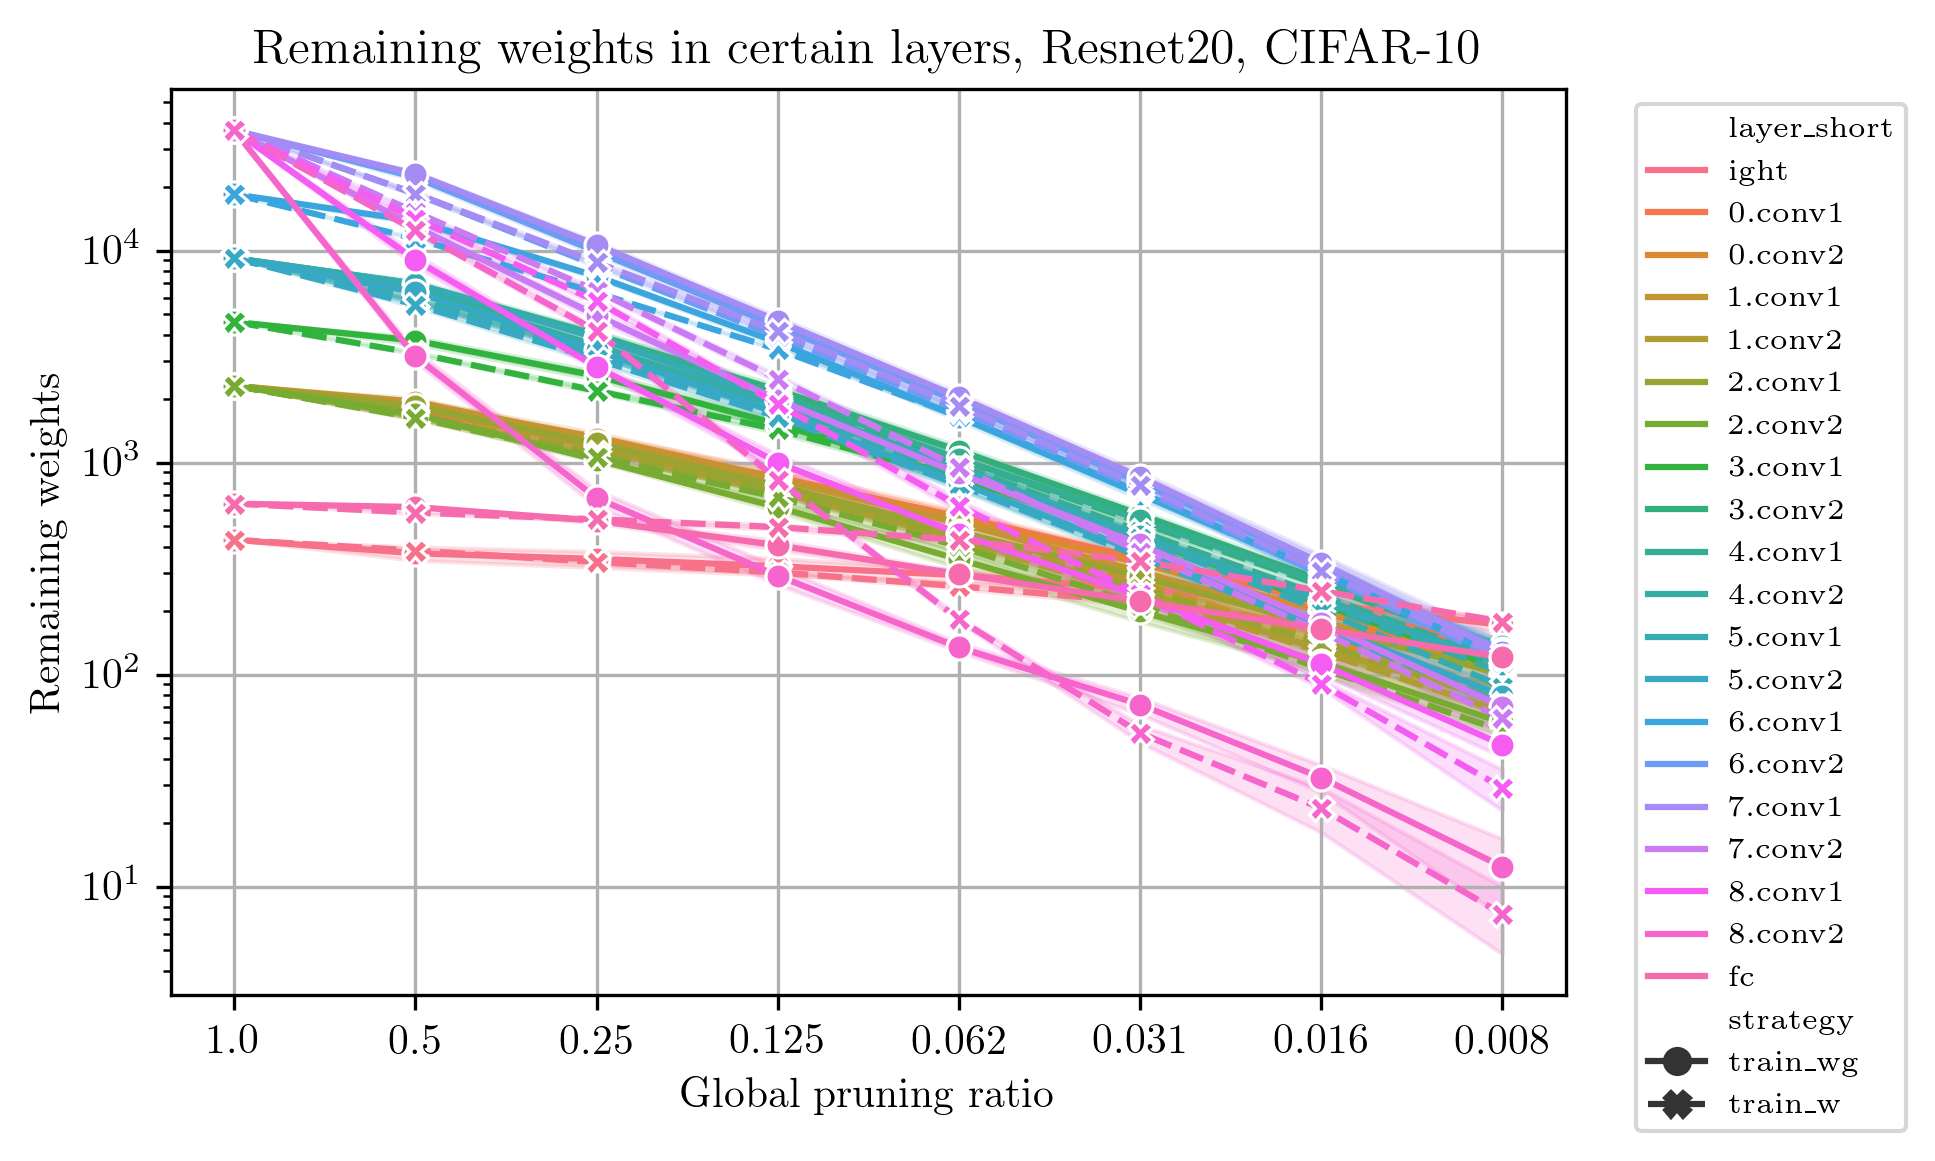

In [102]:
plt.figure(figsize=(6,4), facecolor='white', dpi=300)
ax = sns.lineplot(x="level", y="remaining_parameters", data=df, markers=True, hue='layer\_short', style = 'strategy')
ax.set_xticklabels([str(x) for x in sorted(df['unpruned'].unique(), reverse=True)])
ax.set_title(f'Remaining weights in certain layers, Resnet20, CIFAR-10')
ax.set_ylabel('Remaining weights')
ax.set_xlabel('Global pruning ratio')
ax.set_yscale('log')
#plt.legend(loc=3, fontsize = 'x-small')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 'x-small')

ax.grid()

In [23]:
df.query("strategy == 'train_w' and level == 'level_6' and layer == 'conv11'")

,replicate_id,level,layer,measure,unpruned,strategy,remaining_parameters,layer_type,layer_name
95,replicate_1,level_6,conv11,0.002268,0.016,train_w,5350.0,mask,model.layers.11.conv.weight
247,replicate_2,level_6,conv11,0.002256,0.016,train_w,5323.0,mask,model.layers.11.conv.weight
399,replicate_3,level_6,conv11,0.002180,0.016,train_w,5144.0,mask,model.layers.11.conv.weight
551,replicate_4,level_6,conv11,0.002168,0.016,train_w,5116.0,mask,model.layers.11.conv.weight
703,replicate_5,level_6,conv11,0.002259,0.016,train_w,5330.0,mask,model.layers.11.conv.weight
855,replicate_6,level_6,conv11,0.002204,0.016,train_w,5201.0,mask,model.layers.11.conv.weight


In [110]:
w_df = df.query("strategy == 'train\_w'").groupby(['level', 'layer\_short']).mean()
w_df.insert(0, 'strategy', 'train\_w')
wg_df = df.query("strategy == 'train\_wg'").groupby(['level', 'layer\_short']).mean()
wg_df.insert(0, 'strategy', 'train\_wg')

In [111]:
ratio_df = w_df.join(wg_df, rsuffix='\_wg').reset_index()
ratio_df['ratio'] = ratio_df['remaining_parameters\_wg']/ratio_df['remaining_parameters']


In [117]:
# ratio_df['layer_num'] = ratio_df['layer\_short'].apply(lambda row: int(row.strip('conv')) if 'conv' in row else 20)
# ratio_df = ratio_df.sort_values(['level', 'layer\_short'])#.query('unpruned > 0.007')


In [118]:
ratio_df

,level,layer\_short,strategy,measure,unpruned,remaining_parameters,strategy\_wg,measure\_wg,unpruned\_wg,remaining_parameters\_wg,ratio
0,level_0,0.conv1,train\_w,1.000000,1.000,2304.0,train\_wg,1.000000,1.000,2304.0,1.000000
1,level_0,0.conv2,train\_w,1.000000,1.000,2304.0,train\_wg,1.000000,1.000,2304.0,1.000000
2,level_0,1.conv1,train\_w,1.000000,1.000,2304.0,train\_wg,1.000000,1.000,2304.0,1.000000
3,level_0,1.conv2,train\_w,1.000000,1.000,2304.0,train\_wg,1.000000,1.000,2304.0,1.000000
4,level_0,2.conv1,train\_w,1.000000,1.000,2304.0,train\_wg,1.000000,1.000,2304.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
155,level_7,7.conv2,train\_w,0.001687,0.008,62.2,train\_wg,0.001915,0.008,70.6,1.135048
156,level_7,8.conv1,train\_w,0.000792,0.008,29.2,train\_wg,0.001264,0.008,46.6,1.595890
157,level_7,8.conv2,train\_w,0.000201,0.008,7.4,train\_wg,0.000336,0.008,12.4,1.675676
158,level_7,fc,train\_w,0.277500,0.008,177.6,train\_wg,0.188438,0.008,120.6,0.679054


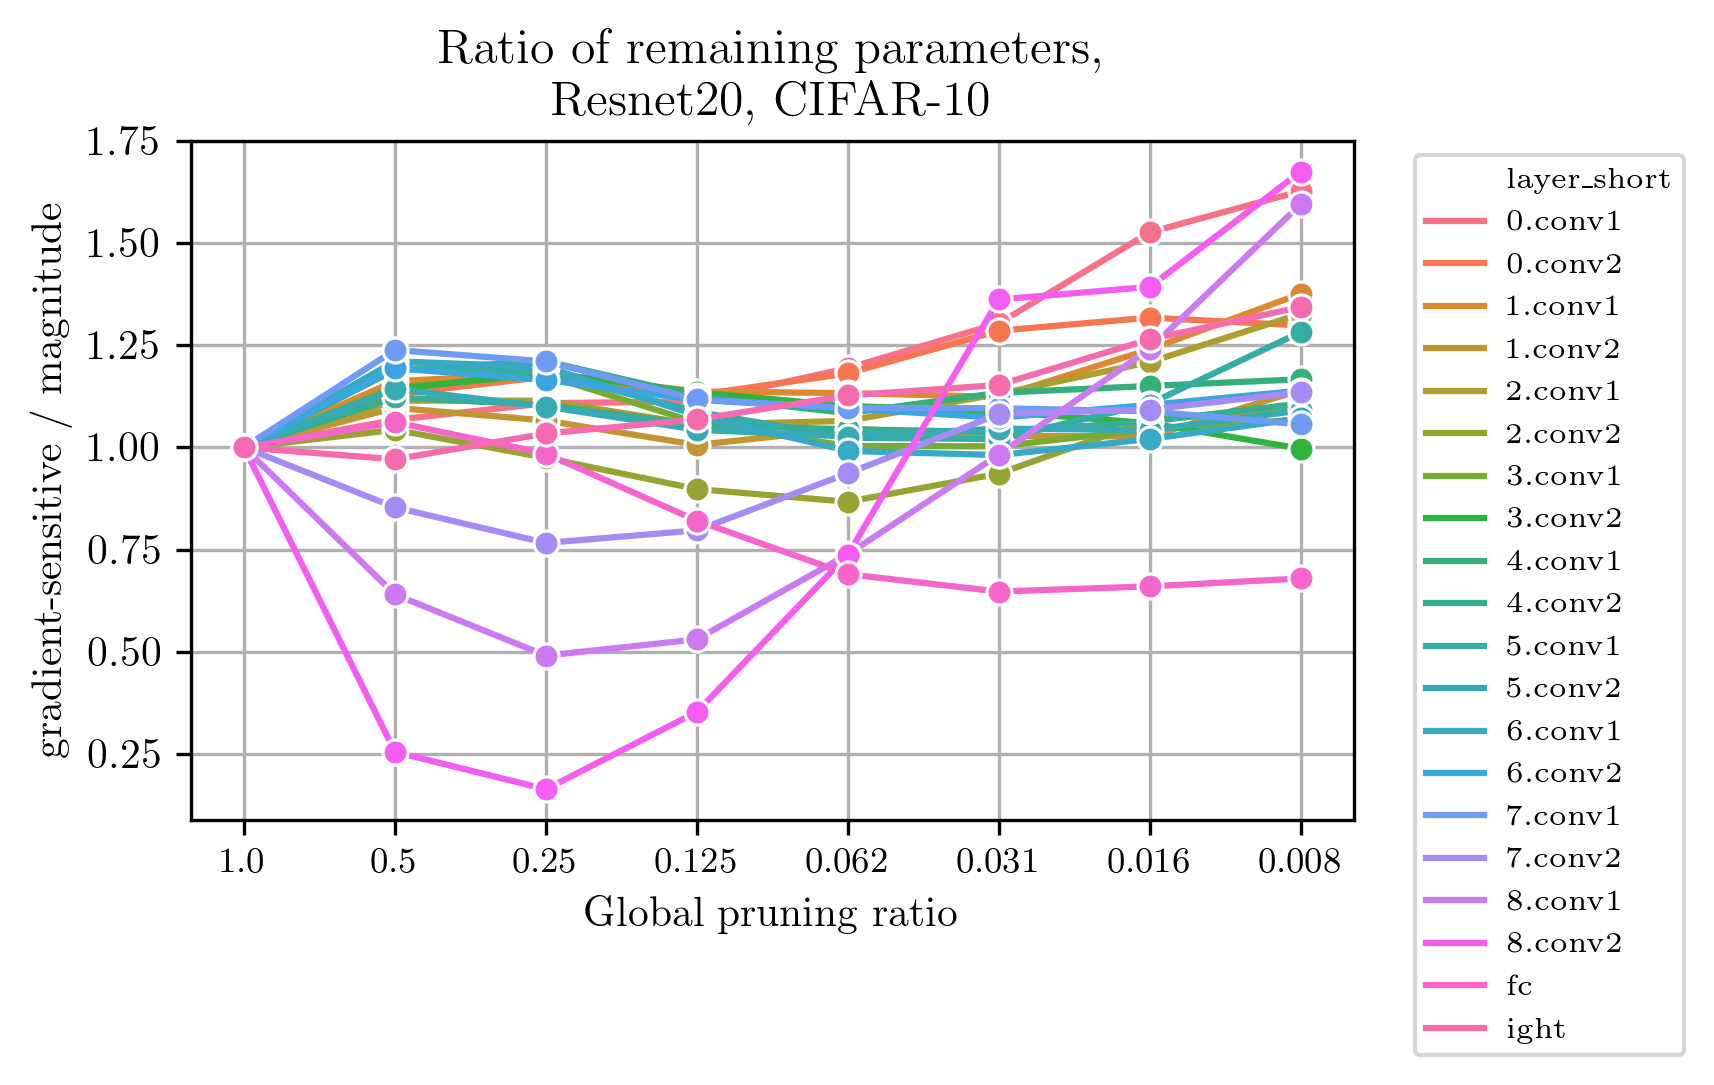

In [120]:
plt.figure(figsize=(5,3), facecolor='white', dpi=300)
ax = sns.lineplot(x="level", y="ratio", data=ratio_df, markers=True, hue='layer\_short', marker='o')
ax.set_xticklabels([str(x) for x in sorted(df['unpruned'].unique(), reverse=True)])
ax.set_title(f'Ratio of remaining parameters, \nResnet20, CIFAR-10')
ax.set_ylabel('gradient-sensitive / magnitude')
ax.set_xlabel('Global pruning ratio')
# ax.set_yscale('log')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 'x-small')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize('small')
ax.grid()

Dataset Hyperparameters
    * dataset_name => cifar10
    * batch_size => 128
    * do_not_augment => True
Model Hyperparameters
    * model_name => cifar_vgg_16
    * model_init => kaiming_normal
    * batchnorm_init => uniform
Pruning Hyperparameters
    * pruning_strategy => snip_global
    * pruning_fraction => 0.5
Training Hyperparameters
    * optimizer_name => sgd
    * lr => 0.1
    * training_steps => 100ep
    * momentum => 0.1
    * milestone_steps => 60ep
    * gamma => 0.1
    * weight_decay => 0.0001


dict_keys(['model.layers.0.conv.weight', 'model.layers.0.conv.bias', 'model.layers.0.bn.weight', 'model.layers.0.bn.bias', 'model.layers.1.conv.weight', 'model.layers.1.conv.bias', 'model.layers.1.bn.weight', 'model.layers.1.bn.bias', 'model.layers.3.conv.weight', 'model.layers.3.conv.bias', 'model.layers.3.bn.weight', 'model.layers.3.bn.bias', 'model.layers.4.conv.weight', 'model.layers.4.conv.bias', 'model.layers.4.bn.weight', 'model.layers.4.bn.bias', 'model.layers.6.conv.weight', 'model.layers.6.conv.bias', 'model.layers.6.bn.weight', 'model.layers.6.bn.bias', 'model.layers.7.conv.weight', 'model.layers.7.conv.bias', 'model.layers.7.bn.weight', 'model.layers.7.bn.bias', 'model.layers.8.conv.weight', 'model.layers.8.conv.bias', 'model.layers.8.bn.weight', 'model.layers.8.bn.bias', 'model.layers.10.conv.weight', 'model.layers.10.conv.bias', 'model.layers.10.bn.weight', 'model.layers.10.bn.bias', 'model.layers.11.conv.weight', 'model.layers.11.conv.bias', 'model.layers.11.bn.weight', 

In [246]:
del data_to_frame
data_to_distplot = defaultdict(list)
index = 0
for layer_name in weight_tensors.keys():
    if isinstance(layer_name, int):
        continue
    data_to_distplot['weights'] += list(weight_tensors[layer_name][index].numpy().flatten())
    data_to_distplot['grad']+= list(grad_tensors[layer_name][index].flatten())
    data_to_distplot['product'] += list((weight_tensors[layer_name][index].numpy() * grad_tensors[layer_name][index]).flatten())

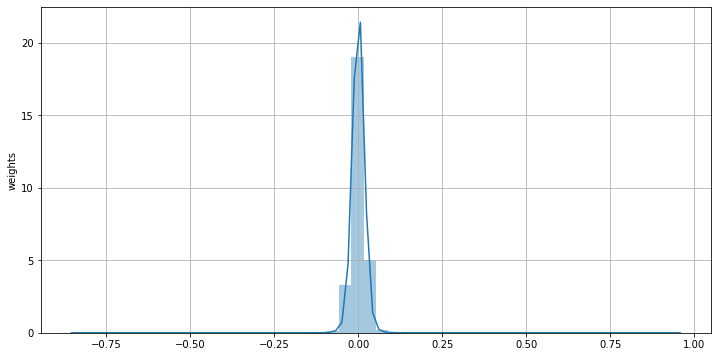

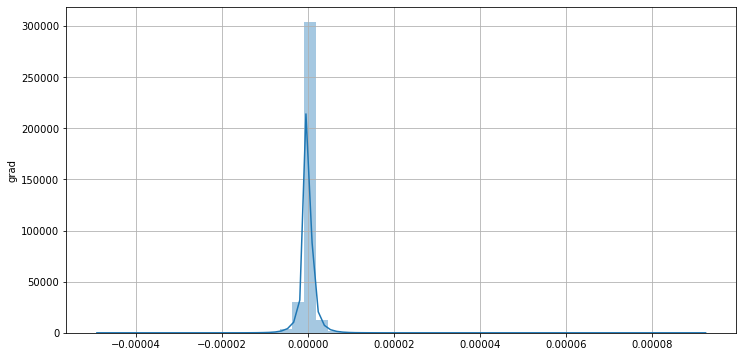

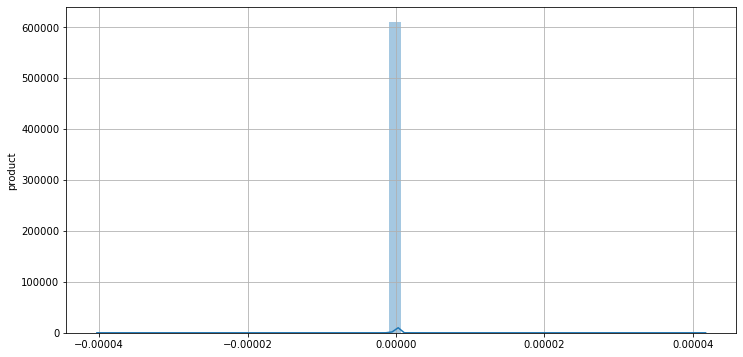

In [250]:
for name, data in data_to_distplot.items():
    plt.figure(figsize = (12,6))
    ax = sns.distplot(data)
    ax.set_xlabel(name)
    ax.grid()
    # ax.set_xlim((-0.1, 0.1))
    plt.show()


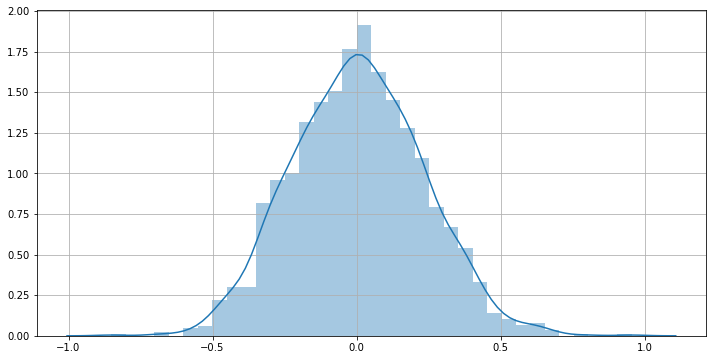

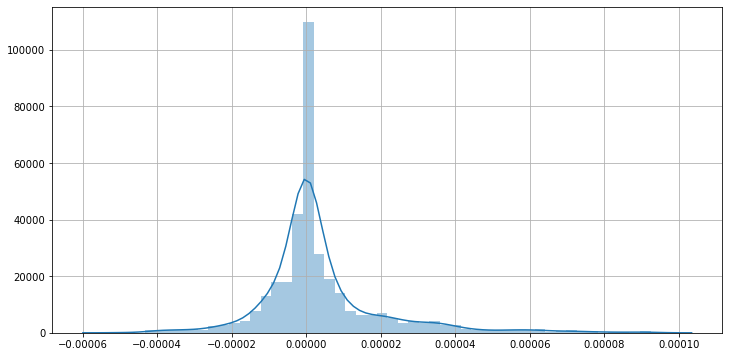

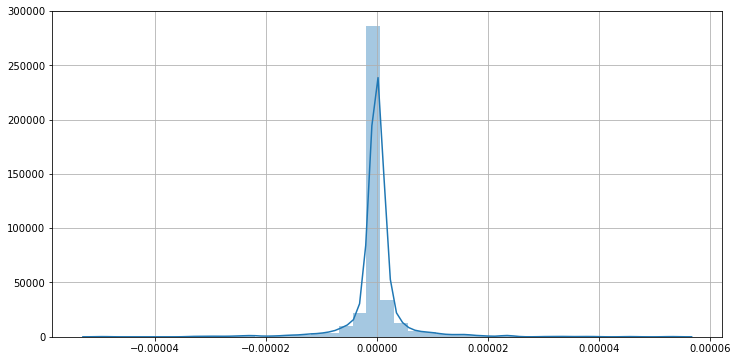

In [229]:
plt.figure(figsize = (12,6))
sns.distplot(weight_tensors['model.layers.0.conv.weight'][0].flatten())
plt.grid()
plt.show()
plt.figure(figsize = (12,6))
sns.distplot(grad_tensors['model.layers.0.conv.weight'][0].flatten())
plt.grid()
plt.show()
plt.figure(figsize = (12,6))
sns.distplot((grad_tensors['model.layers.0.conv.weight'][0]*weight_tensors['model.layers.0.conv.weight'][-1].numpy()).flatten())
plt.grid()
plt.show()